# Utilities

In [282]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy.stats import norm
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image

from abc import ABC, abstractmethod
from collections.abc import Iterable

In [283]:
savefig = False # Indicate if we want to save the figures

In [284]:
class TranslocationModel(ABC):
    """A translocation model defined by a kinetic scheme.
    
    The kinetic scheme is a directed graph where the nodes are the states of
    the system and the edges are the reactions. The nodes have a 'probability'
    attribute, which is the probability of the steady-state system to be in
    this state. The directed edges have a 'rate' attribute, which is the rate
    of the reaction. Edges may have other attributes indicating the evolution of
    other physical quantities, such as 'ATP' or 'position'.
    'rate' and 'probability' attributes are functions that return the value of
    the rate/probability dynamically. This means that if the quantity depends on
    a physical parameter the value of the quantity will be updated when the 
    physical parameter is modified.

    The translocation model is a stochastic process. It can be simulated using
    the Gillespie algorithm. The stochastic process is a single particle
    evoluting on the kinetic scheme. 

    We are interested in the position of the particle over time, for various
    models such as 'Sequential Clockwise/2-Residue Step' or 'Disc-Spiral'.

    A model is a subclass of TranslocationModel. It must implement the 
    _construct_kinetic_scheme method, which constructs the kinetic scheme of
    the model, and then call it in the constructor to construct the attribute
    self.kinetic_scheme. 

    Physical parameters:
        ATP_ADP_ratio: The ATP/ADP ratio.
        equilibrium_ATP_ADP_ratio: The equilibrium ATP/ADP ratio.
        k_on_ATP: The association rate of ATP to the protomer.
        k_off_ATP: The dissociation rate of ATP from the protomer.
        k_on_ADP: The association rate of ADP to the protomer.
        k_off_ADP: The dissociation rate of ADP from the protomer.
        k_h: The ATP hydrolysis rate.
        k_s: The ATP synthesis rate.
        K_d_ATP: The protomer-ATP dissociation constant.
        K_d_ADP: The protomer-ADP dissociation constant.


    Remark for code maintainers:
    The way it is implemented right now, the probabilities are computed each
    time they are needed. If the models become more complex, it may be a costly
    operation. It may be better to store the probabilities somewhere and update
    them automatically when any physical parameter is modified.
    For the models we have right now, it is not a problem.
    """

    def __init__(self, ATP_ADP_ratio: float = 10,): 
        self.equilibrium_ATP_ADP_ratio = 1
        self._ATP_ADP_ratio = ATP_ADP_ratio
        # Association/dissociation protomer-ATP/ADP rates
        self.k_on_ATP = 1
        self.k_off_ATP = 1
        self.k_on_ADP = 1
        self.k_off_ADP = 1
        # ATP hydrolysis/synthesis rates
        self.k_h = 1
        self.k_s = 1
        
        self.kinetic_scheme = None # TODO abstract attribute
        
    @property
    def ATP_ADP_ratio(self) -> float:
        """ATP/ADP concentrations ratio."""
        return self._ATP_ADP_ratio
    
    @ATP_ADP_ratio.setter
    def ATP_ADP_ratio(self, value: float) -> None:
        if value < 0:
            raise ValueError("The ATP/ADP ratio must be nonnegative.")
        self._ATP_ADP_ratio = value

    @property
    def K_d_ATP(self) -> float: 
        """Protomer-ATP dissociation constant."""
        return self.k_off_ATP / self.k_on_ATP

    @property
    def K_d_ADP(self) -> float: 
        """Protomer-ATP dissociation constants"""
        return self.k_off_ADP / self.k_on_ADP

    # TODO automate probabilities update when physical parameters are modified
    # maybe using __setattr__

    
    def gillespie(
        self, 
        n_steps: int = 1000, 
        initial_state: None | str = None,
        n_simulations: int = 1,
        cumulative_sums: str | list[str] | None = None,
    ) -> pd.DataFrame | list[pd.DataFrame]:
        """Simulate the stochastic system using the Gillespie algorithm.

        Simulate the stochastic evolution of a single particle evoluting on 
        the kinetic scheme using the Gillespie algorithm.

        Args:
            n_steps: The number of simulation steps.
            initial_state: The initial state of the system. If None, a random
                initial state is chosen.
            n_simulations: The number of simulations to do. If > 1, the returned
                object is a list of dataframes, one for each simulation.
            cumulative_sums: The edge attributes to compute the cumulative sum
                of. Each simulation result dataframe then contains new columns
                named 'attribute_name' with the cumulative sum of the specified
                edge attributes at each step, with the timestamp. It adds a
                row at the beginning with timestamp 0 and 0 value at each
                column. 
                If None, each simulation returns a dataframe with the timestamp 
                and the edge taken at each step with all its attributes.

        Returns:
            A dataframe (or a list of dataframes if n_simulations > 1) with the
            columns 'timestamp', 'edge' and the elements of 'cumulative_sums'.
            The 'edge' column contains tuples of the form 
            (state_from, state_to, attributes), where attributes is a dict of 
            the form 'attribute': value.
        """
        if n_steps < 1:
            raise ValueError(
                "The number of steps must be strictly greater than 0.")
        if initial_state and initial_state not in self.kinetic_scheme.nodes():
            raise ValueError("The initial state does not belong to the graph.")
        if n_simulations < 1:
            raise ValueError(
                "The number of simulations must be strictly greater than 0.")

        results = []
        for _ in range(n_simulations):
            result = {'timestamp': [], 'edge': []}

            time = 0
            state = (initial_state if initial_state 
                     else np.random.choice(list(self.kinetic_scheme.nodes()))) # TODO init with probabilities
            for _ in range(n_steps):
                # Each step the system starts in the current state and then 
                # after a sojourn time given by an exponential distribution
                # with parameter the sum of the leaving rates of the current 
                # state, it goes to the next state chosen with probability 
                # proportional to the leaving rates.
                out_edges = list(
                    self.kinetic_scheme.out_edges(state, data=True))
                total_rate = sum(
                    [attributes['rate']() for _, _, attributes in out_edges])
                sojourn_time = np.random.exponential(1/total_rate)
                chosen_edge_i = np.random.choice(
                    list(range(len(out_edges))), 
                    p=[attributes['rate']()/total_rate 
                       for _, _, attributes in out_edges])
                chosen_edge = out_edges[chosen_edge_i]
                
                time += sojourn_time
                state = chosen_edge[1]

                result['timestamp'].append(time)
                result['edge'].append(chosen_edge)
            result = pd.DataFrame(result)
            if cumulative_sums:
                self._compute_cumulative_sums(result, cumulative_sums)
            results.append(result)

        if n_simulations == 1:
            out = results[0]
        else:
            out = results

        return out

    def plot_position_evolution(
        self, 
        trajectory: pd.DataFrame | list[pd.DataFrame],
        time_unit: str, 
        position_unit: str = "#Residues", 
        kinetic_scheme_image_path: str | None = None, 
        ax: mpl.axes.Axes | None = None,
        title: str | None = None,
    ) -> mpl.axes.Axes:
        """Plot the evolution of the position.

        Plot the expected position given by the average velocity.

        Args:
            trajectory: Position and timestamp at every changement of the 
                position (in residues, not steps). It must have these two
                columns: 'timestamp' and 'position'. It can also be a list of
                dataframes, one for each simulation. In this case, every 
                trajectory is plotted on the same axes.
            time_unit: Unit of the time (x-)axis
            position_unit: Unit of the position (y-)axis
            kinetic_scheme_image_path: If given, will add the image of the
                kinetic scheme on the plot.
            ax: The axes where to plot. If None, a new axes is created.
            title: The title of the plot. If None, no title is added.

        Returns:
            The axes with the plot.
        """

        if not ax:
            _, ax = plt.subplots()
        
        # Single or multiple trajectories handled the same way in a list
        trajectories = (
            trajectory 
            if isinstance(trajectory, list) 
            else [trajectory])
        for i, trajectory in enumerate(trajectories):
            label = "From Gillespie algorithm" if i == 0 else None
            ax.step(trajectory['timestamp'], trajectory['position'], 
                    where="post", label=label, color='C0')
        ax.plot(trajectories[0]['timestamp'], 
                trajectories[0]['timestamp'] * self.average_velocity(), 
                label="From average velocity", color='C3')
        ax.set_xlabel("Time" + " [" + time_unit + "]")
        ax.set_ylabel("Position" + " [" + position_unit + "]")
        ax.legend() # TODO only one color for all trajectories
        if kinetic_scheme_image_path:
            img = np.asarray(Image.open(kinetic_scheme_image_path))
            sub_ax = ax.inset_axes([0.55, 0., 0.44, 0.44])
            sub_ax.imshow(img)
            sub_ax.axis('off')

        if title:
            ax.set_title(title)

        return ax
    
    def average_velocity(self) -> float:
        """Return the average velocity of the translocation model.

        The average velocity is the sum of rate times the probability of initial
        state times the displacement.
        """
        velocity = 0
        for u, v, displacement in self.kinetic_scheme.edges(data='position', 
                                                            default=0):
            velocity += (displacement 
                         * self.kinetic_scheme.nodes[u]['probability']() 
                         * self.kinetic_scheme.edges[u, v]['rate']())
        return velocity
    
    def ATP_consumption_rate(self) -> float:
        """Return the ATP consumption rate of the translocation model."""
        r = 0
        for u, v, ATP in self.kinetic_scheme.edges(data='ATP', 
                                                            default=0):
            r += (ATP 
                  * self.kinetic_scheme.nodes[u]['probability']() 
                  * self.kinetic_scheme.edges[u, v]['rate']())
    
    def normalize_average_velocity(self, inplace: bool = False
    ) -> nx.DiGraph | None: 
        """Normalize the average velocity of the translocation model.

        Update all the rates so that the average velocity is 1.
        Can be used to compare different models.
        """
        if self.average_velocity() == 0:
            raise ValueError("The average velocity is null, cannot normalize.")
        
        average_velocity = self.average_velocity() # Velocity before normalization
        kinetic_scheme = (self.kinetic_scheme if inplace 
                          else self.kinetic_scheme.copy())
        for edge in kinetic_scheme.edges():
            kinetic_scheme.edges[edge]['rate'] = (
                lambda old_rate_lambda=kinetic_scheme.edges[edge]['rate']: 
                    old_rate_lambda() / average_velocity)
        return kinetic_scheme
    
    def analytical_attribute_stats(# TODO debug variance (and CI)
            self,
            edge_attribute: str,
            time: float,
            confidence_level: float = 0.95,

    ) -> tuple[float, float, tuple[float, float]]:
        """Return mean, std and confidence interval of the edge attribute.
        
        Return the mean, standard deviation (std) and confidence interval
        (CI) at the specified confidence level of the specified edge attribute. 
        The confidence interval (CI) is computed with gaussian approximation.

        The computation of the statistics of the edge attribute are based on the 
        probability distribution of passage on the edge. Mathematical details 
        are given in the report.

        Args:
            edge_attribute: The edge attribute to compute the statistics of.
            time: The time to compute the statistics at.
            confidence_level: The confidence level of the confidence interval. 
                Only relevant if confidence_interval is True.
        
        Returns:
            Nested tuples (mean, std, (CI lower bound, CI upper bound)).
        """
        mean = 0
        var = 0
        for u, v, value in self.kinetic_scheme.edges(data=edge_attribute, default=0):
            edge_mean, edge_var = self._edge_passage_mean_var(u, v, time)
            mean += edge_mean * value
            var += edge_var * value**2
        std = np.sqrt(var)
        confidence_interval = norm.interval(confidence_level, mean, std)
        return mean, std, confidence_interval

    #TODO Verify this, generated by copilot and not read
    def numerical_attribute_stats(
        self,
        edge_attribute: str,
        time: float,
        n_simulations: int = 1000,
        confidence_level: float = 0.95,
    ) -> tuple[float, float, tuple[float, float]]:
        """Return mean, std and confidence interval of the edge attribute.
        
        Return the mean, standard deviation (std) and confidence interval
        (CI) at the specified confidence level of the specified edge attribute. 
        The confidence interval (CI) is computed with gaussian approximation.

        The computation of the statistics of the edge attribute are based on the 
        probability distribution of passage on the edge. Mathematical details 
        are given in the report.

        Args:
            edge_attribute: The edge attribute to compute the statistics of.
            time: The time to compute the statistics at.
            confidence_level: The confidence level of the confidence interval. 
                Only relevant if confidence_interval is True.
        
        Returns:
            Nested tuples (mean, std, (CI lower bound, CI upper bound)).
        """
        if n_simulations < 2:
            raise ValueError(
                "The number of simulations must be at least 2.")
        
        results = self.gillespie(
            n_steps=n_simulations,
            cumulative_sums=edge_attribute,
        )
        results = (
            results 
            if isinstance(results, list) 
            else [results])
        means = []
        for result in results:
            mean = result[edge_attribute].iloc[-1] / time
            means.append(mean)
        mean = np.mean(means)
        std = np.std(means)
        confidence_interval = norm.interval(confidence_level, mean, std)
        return mean, std, confidence_interval

    @abstractmethod
    def _construct_kinetic_scheme(
        self, 
        kinetic_scheme: nx.DiGraph | None = None
    ) -> nx.DiGraph:
        """Construct the kinetic scheme of the translocation model.
        
        The kinetic scheme is a directed graph where the nodes are the states of
        the system and the edges are the reactions. The nodes have a 'probability'
        attribute, which is the probability of the steady-state system to be in
        this state. The directed edges have a 'rate' attribute, which is the rate
        of the reaction. Edges may have other attributes indicating the evolution of
        other physical quantities, such as 'ATP' or 'position'.
        """
        pass

    def _compute_probabilities(self) -> dict[str, float]:
        """Compute the steady-state probabilities of the kinetic scheme.
        
        Return a dictionary of form 'node_name': probability.
        """
        sorted_nodes = sorted(self.kinetic_scheme.nodes())
        # Update matrix M of the system \dot{p} = M p
        """M = (nx.adjacency_matrix(self.kinetic_scheme, 
                                 nodelist=sorted_nodes, 
                                 weight='rate')
             .toarray()
             .T)"""
        M = np.zeros((len(sorted_nodes), len(sorted_nodes)))
        for node in sorted_nodes:
            for neighbor, _, attributes in self.kinetic_scheme.in_edges(
                node, data=True
            ):
                M[sorted_nodes.index(node), sorted_nodes.index(neighbor)] = (
                    attributes['rate']())
        M = M - np.diag(M.sum(axis=0))
        # To solve we add the constraint that the sum of probabilities is 1
        # and we take advantage of the fact that the kernel of M has dimension 1
        M[-1, :] = np.ones(M.shape[1])
        b = np.zeros(M.shape[0])
        b[-1] = 1
        # Probabilities are then given by the solution of the linear system
        probabilities = np.linalg.solve(M, b)
        return {node: probability 
                for node, probability in zip(sorted_nodes, probabilities)}
    
    def _compute_cumulative_sums(
        self,
        result: pd.DataFrame,
        cumulative_sums: str | list[str], # TODO str or list[str] instead of dict and modify displacement to position
    ) -> None:
        """Compute the cumulative sum of the specified edge attributes.

        The post-processing consists in computing the cumulative sum of the
        specified edge attributes at each step. 
        The result is updated in-place.

        Args:
            result: A dataframe with the columns 'timestamp' and 'edge'. The
                'edge' column contains tuples of the form 
                (state_from, state_to, attributes), where attributes is a dict
                of the form 'attribute': value.
            cumulative_sums: (list of) 'edge_attribute' for which to compute the
                cumulative sum.
        """
        if isinstance(cumulative_sums, str):
            cumulative_sums = [cumulative_sums]
        for edge_attribute in cumulative_sums:
            result[edge_attribute] = (
                result['edge']
                .apply(lambda edge: edge[2].get(edge_attribute))
                .cumsum())
        # Add a row at the beginning with timestamp 0 and value 0 at each column
        result.loc[-1] = [0] + [None] + [0] * len(cumulative_sums)
        result.index += 1
        result.sort_index(inplace=True)
        # Fill None values in the cumulative sum columns with last valid value
        result.ffill(inplace=True)

    def _edge_passage_mean_var(self, u: str, v: str, t: float
    ) -> tuple[float, float]:
        """Compute the mean and variance of number of passage on the edge.
        
        Args:
            u, v: The initial and final nodes of the edge.
            t: The time to compute the statistics at.

        Returns:
            A tuple (mean, variance).
        """
        p = self.kinetic_scheme.nodes[u]['probability']()
        k = self.kinetic_scheme.edges[u, v]['rate']()
        mean = p * k * t
        variance = p * k * t * (1 + k * t * (1 - p))
        return mean, variance
    




# Models

In [285]:
class SequentialClockwise2ResidueStep(TranslocationModel):
    """Sequential Clockwise/2-Residue Step.
    
    Physical parameters:
        k_DT: Effective ATP->ADP exchange rate.
        k_TD: Effective ADP->ATP exchange rate.
        k_up: Translocation up rate.
        k_down: Translocation down rate.
    """

    def __init__(self, ATP_ADP_ratio: float = 10) -> None:
        super().__init__(ATP_ADP_ratio)

        self.k_DT = 1 # Effective ADP->ATP exchange rate
        self.k_up = 1 # Translocation up rate
    
    @property
    def k_TD(self) -> float:
        """Effective ATP->ADP exchange rate.
        
        It is constrained by the ATP/ADP exchange model.
        """
        return (
            self.k_DT
            * self.K_d_ATP
            / self.K_d_ADP
            / self.ATP_ADP_ratio
        )
    
    @property
    def k_down(self) -> float:
        """Translocation down rate.
        
        It is constrained by the thermodynamics of the kinetic scheme.
        """
        return (
            self.k_h
            * self.k_up
            * self.k_DT
            / (self.k_s * self.k_TD)
            * self.equilibrium_ATP_ADP_ratio
            / self.ATP_ADP_ratio
        )


class SC2R1Loop(SequentialClockwise2ResidueStep):
    """Sequential Clockwise/2-Residue Step, 1-Loop translocation model."""

    def __init__(self, ATP_ADP_ratio: float = 10) -> None:
        super().__init__(ATP_ADP_ratio)
        self.kinetic_scheme = self._construct_kinetic_scheme()

    def _construct_kinetic_scheme(self, kinetic_scheme: nx.DiGraph | None = None
    ) -> nx.DiGraph:
        if not kinetic_scheme:
            kinetic_scheme = nx.DiGraph()
        kinetic_scheme.add_nodes_from([
            ('TTT', {'probability': 
                        lambda: self._compute_probabilities()['TTT']}),
            ('DTT', {'probability':
                        lambda: self._compute_probabilities()['DTT']}),
            ('TTD', {'probability': 
                        lambda: self._compute_probabilities()['TTD']})
        ])
        kinetic_scheme.add_edges_from([
            ('TTT', 'DTT', {'rate': lambda: self.k_h, 'name': 'k_h', 
                            'ATP': -1}),
            ('DTT', 'TTT', {'rate': lambda: self.k_s, 'name': 'k_s',
                            'ATP': 1}),
            ('DTT', 'TTD', {'rate': lambda: self.k_up, 'name': 'k_up', 
                            'position': 2}), 
            ('TTD', 'DTT', {'rate': lambda: self.k_down, 'name': 'k_down', 
                            'position': -2}),
            ('TTD', 'TTT', {'rate': lambda: self.k_DT, 'name': 'k_DT'}), 
            ('TTT', 'TTD', {'rate': lambda: self.k_TD, 'name': 'k_TD'})
        ])
        return kinetic_scheme
    

class SC2R2Loops(SequentialClockwise2ResidueStep):
    """Sequential Clockwise/2-Residue Step, 2-Loops translocation model."""

    def __init__(self, ATP_ADP_ratio: float = 10) -> None:
        super().__init__(ATP_ADP_ratio)
        self.kinetic_scheme = self._construct_kinetic_scheme()
    
    def _construct_kinetic_scheme(self, kinetic_scheme: nx.DiGraph | None = None
    ) -> nx.DiGraph:
        if not kinetic_scheme:
            kinetic_scheme = nx.DiGraph()
        kinetic_scheme.add_nodes_from([
            ('TTT', {'probability': 
                        lambda: self._compute_probabilities()['TTT']}),
            ('DTT', {'probability':
                        lambda: self._compute_probabilities()['DTT']}),
            ('TTD', {'probability': 
                        lambda: self._compute_probabilities()['TTD']}),
            ('DTD', {'probability': 
                        lambda: self._compute_probabilities()['DTD']})
        ])
        kinetic_scheme.add_edges_from([
            # Main loop
            ('TTT', 'DTT', {'rate': lambda: self.k_h, 'name': 'k_h', 
                            'ATP': -1}),
            ('DTT', 'TTT', {'rate': lambda: self.k_s, 'name': 'k_s',
                            'ATP': 1}),
            ('DTT', 'TTD', {'rate': lambda: self.k_up, 'name': 'k_up', 
                            'position': 2}),
            ('TTD', 'DTT', {'rate': lambda: self.k_down, 'name': 'k_down', 
                            'position': -2}),
            ('TTD', 'TTT', {'rate': lambda: self.k_DT, 'name': 'k_DT'}),
            ('TTT', 'TTD', {'rate': lambda: self.k_TD, 'name': 'k_TD'}),
            # Second loop
            ('DTT', 'DTD', {'rate': lambda: self.k_TD, 'name': 'k_TD'}),
            ('DTD', 'DTT', {'rate': lambda: self.k_DT, 'name': 'k_DT'}),
            ('DTD', 'TTD', {'rate': lambda: self.k_s, 'name': 'k_s', 
                            'ATP': 1}),
            ('TTD', 'DTD', {'rate': lambda: self.k_h, 'name': 'k_h',
                            'ATP': -1})
        ])
        return kinetic_scheme


class DiscSpiral(TranslocationModel):
    """Disc-Spiral translocation model.
    
    Physical parameters:
        k_DT
        k_TD
        k_[extended/flat]_to_[flat/extended]_[up/down]
    """

    def __init__(self, ATP_ADP_ratio: float = 10, n_protomers: int = 6) -> None:
        super().__init__(ATP_ADP_ratio)

        self.n_protomers = n_protomers
        self.k_DT = 1 # Effective ADP->ATP exchange rate
        self.k_extended_to_flat_up = 1 # Spiral->disc up translocation rate
        self.k_flat_to_extended_down = 1 # Disc->spiral down translocation rate
        self.k_flat_to_extended_up = 1 # Disc->spiral up translocation rate

        self.kinetic_scheme = self._construct_kinetic_scheme()
    
    @property
    def k_TD(self) -> float:
        """Effective ATP->ADP exchange rate.
        
        It is constrained by the ATP/ADP exchange model.
        """
        return (
            self.k_DT
            * self.K_d_ATP
            / self.K_d_ADP
            / self.ATP_ADP_ratio
        )
    
    @property
    def k_bar_h(self) -> float:
        """Effective ATP hydrolisis rate.
        
        Each protomer contributes k_h to the effective hydrolisis rate.
        """
        return self.n_protomers * self.k_h
    
    @property
    def k_extended_to_flat_down(self) -> float:
        """Spiral->disc down translocation rate.
        
        It is constrained by the thermodynamics of the kinetic scheme.
        """
        return (self.k_bar_h 
                * self.k_flat_to_extended_up 
                * self.k_DT 
                * self.k_extended_to_flat_up 
                / (self.k_s * self.k_TD * self.k_flat_to_extended_down)
                * self.equilibrium_ATP_ADP_ratio
                / self.ATP_ADP_ratio
        )

    def _construct_kinetic_scheme(self, kinetic_scheme: nx.DiGraph | None = None
    ) -> nx.DiGraph:
        if not kinetic_scheme:
            kinetic_scheme = nx.DiGraph()
        kinetic_scheme.add_nodes_from([
            ('flat-ATP', {'probability': 
                        lambda: self._compute_probabilities()['flat-ATP']}),
            ('flat-ADP', {'probability':
                        lambda: self._compute_probabilities()['flat-ADP']}),
            ('extended-ATP', {'probability': 
                        lambda: self._compute_probabilities()['extended-ATP']}),
            ('extended-ADP', {'probability': 
                        lambda: self._compute_probabilities()['extended-ADP']})
        ])
        kinetic_scheme.add_edges_from([ # ⤴⤵⤷↳↱ 
            ('flat-ATP', 'flat-ADP', {
                'rate': lambda: self.k_bar_h, 
                'name': 'k_bar_h', #\bar{k}_h
                'ATP': -1}),
            ('flat-ADP', 'flat-ATP', {
                'rate': lambda: self.k_s, 
                'name': 'k_s',
                'ATP': 1}),
            ('flat-ADP', 'extended-ADP', {
                'rate': lambda: self.k_flat_to_extended_up, 
                'name': 'k_flat_to_extended_up', # k_⤴
                'position': 2*(self.n_protomers-1)}),
            ('extended-ADP', 'flat-ADP', {
                'rate': lambda: self.k_extended_to_flat_down,
                'name': 'k_extended_to_flat_down', # k_↳
                'position': -2*(self.n_protomers-1)}),
            ('extended-ADP', 'extended-ATP', {
                'rate': lambda: self.k_DT, 
                'name': 'k_DT'}),
            ('extended-ATP', 'extended-ADP', {
                'rate': lambda: self.k_TD, 
                'name': 'k_TD'}),
            ('extended-ATP', 'flat-ATP', {
                'rate': lambda: self.k_extended_to_flat_up,
                'name': 'k_extended_to_flat_up'}), # k_↱
            ('flat-ATP', 'extended-ATP', {
                'rate': lambda: self.k_flat_to_extended_down,
                'name': 'k_flat_to_extended_down'}) # k_⤵
        ])
        return kinetic_scheme





# Simple Gillespie trajectories

## Spiraling in Control: Sequential Clockwise/2-Residue Step



### 1 loop

![](SC_2R_1_loop_kinetic_scheme.jpg)

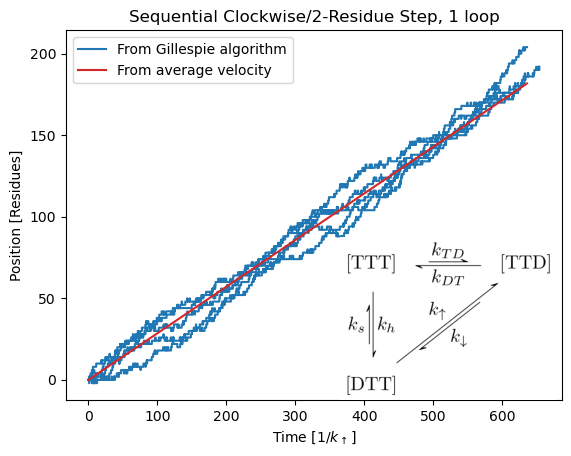

In [286]:
SC_2R_1_loop = SC2R1Loop()
trajectories = SC_2R_1_loop.gillespie(n_simulations=5, 
    cumulative_sums=['position', 'ATP'])
ax = SC_2R_1_loop.plot_position_evolution(
    list(trajectory[['timestamp', 'position']] for trajectory in trajectories),
    time_unit=r"$1/k_\uparrow$", 
    position_unit="Residues", 
    kinetic_scheme_image_path="SC_2R_1_loop_kinetic_scheme.jpg",
    title="Sequential Clockwise/2-Residue Step, 1 loop"
)
plt.show()

### 2 loops

![](SC_2R_2_different_loops_kinetic_scheme.jpg)

TODO create image

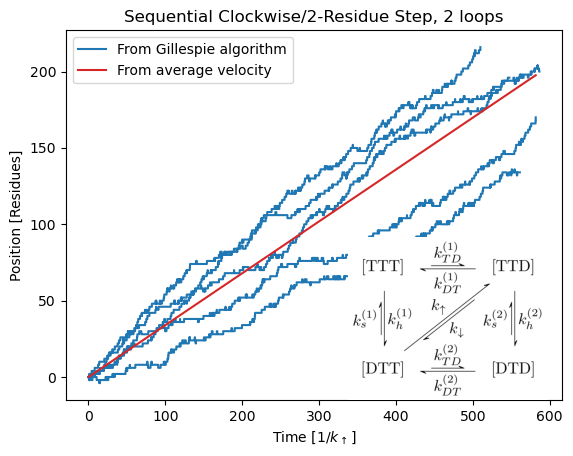

In [287]:
SC_2R_2_loops = SC2R2Loops()
trajectories = SC_2R_2_loops.gillespie(n_simulations=5,
    cumulative_sums=['position', 'ATP'])
ax = SC_2R_2_loops.plot_position_evolution(
    list(trajectory[['timestamp', 'position']] for trajectory in trajectories),
    time_unit=r"$1/k_\uparrow$", 
    position_unit="Residues", 
    kinetic_scheme_image_path="SC_2R_2_different_loops_kinetic_scheme.jpg",
    title="Sequential Clockwise/2-Residue Step, 2 loops"
)
plt.show()

## Disc-Spiral model

![](Disc_spiral_kinetic_scheme.jpg)

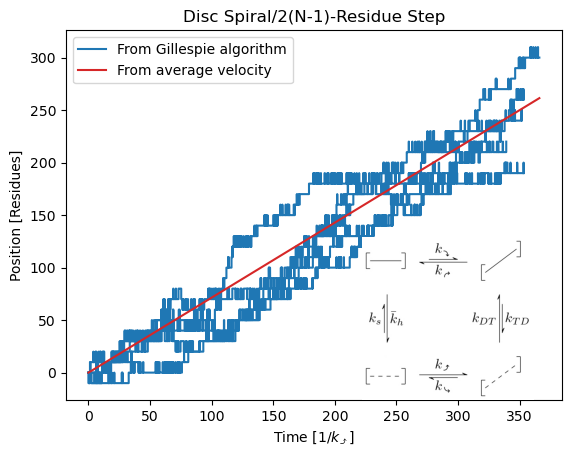

In [288]:
disc_spiral = DiscSpiral()
trajectories = disc_spiral.gillespie(n_simulations=5,
    cumulative_sums={'position': 'displacement', 'ATP': 'ATP'})
ax = disc_spiral.plot_position_evolution(
    list(trajectory[['timestamp', 'position']] for trajectory in trajectories),
    time_unit=r"$1/k_⤴$", 
    position_unit="Residues", 
    kinetic_scheme_image_path="Disc_spiral_kinetic_scheme.jpg",
    title="Disc Spiral/2(N-1)-Residue Step"
)
plt.show()

# Experiments

## Relation between ATP/ADP concentrations ratio and velocity

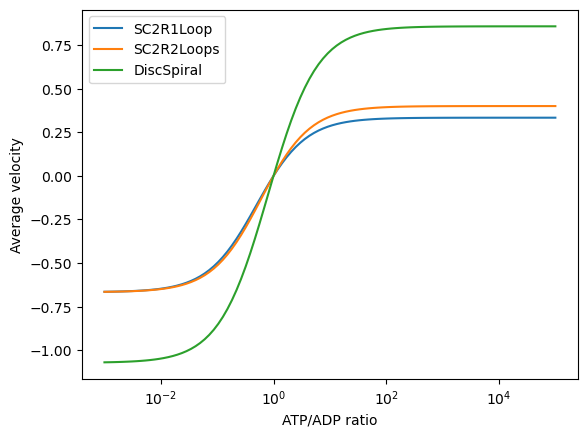

In [289]:
models = [SC2R1Loop(), SC2R2Loops(), DiscSpiral()]
ratios = np.logspace(-3, 5, 100) * SC_2R_1_loop.equilibrium_ATP_ADP_ratio
velocities = {model: [] for model in models}
for ratio in ratios:
    for model in models:
        model.ATP_ADP_ratio = ratio
        velocities[model].append(model.average_velocity())

for model in models:
    plt.plot(ratios, velocities[model], label=model.__class__.__name__)
plt.xscale('log')
plt.xlabel("ATP/ADP ratio")
plt.ylabel("Average velocity")
plt.legend()
plt.show()

## Sequential Clockwise/2-Residue Step, comparison between 1 and 2 loops

In [290]:
# 1 loop and 2 loops models
SC_2R_1_loop = SC2R1Loop()
SC_2R_2_loops = SC2R2Loops()

ATP_ADP_ratios = np.logspace(-1, 1, 10)
for ATP_ADP_ratio in ATP_ADP_ratios:
    print("ATP/ADP:", ATP_ADP_ratio)
    SC_2R_1_loop.ATP_ADP_ratio = ATP_ADP_ratio
    SC_2R_2_loops.ATP_ADP_ratio = ATP_ADP_ratio
    print({node: attributes['probability']() 
           for node, attributes 
           in SC_2R_1_loop.kinetic_scheme.nodes(data=True)})
    print({node: attributes['probability']() 
           for node, attributes 
           in SC_2R_2_loops.kinetic_scheme.nodes(data=True)})



ATP/ADP: 0.1
{'TTT': 0.08333333333333333, 'DTT': 0.33333333333333337, 'TTD': 0.5833333333333334}
{'TTT': 0.03736263736263736, 'DTT': 0.07692307692307691, 'TTD': 0.33406593406593404, 'DTD': 0.5516483516483516}
ATP/ADP: 0.16681005372000587
{'TTT': 0.12508063787386262, 'DTT': 0.3333333333333333, 'TTD': 0.541586028792804}
{'TTT': 0.06285529607164458, 'DTT': 0.11117482042019278, 'TTD': 0.3284880760923012, 'DTD': 0.4974818074158614}
ATP/ADP: 0.2782559402207124
{'TTT': 0.17876891510895462, 'DTT': 0.3333333333333333, 'TTD': 0.48789775155771203}
{'TTT': 0.10180497553128667, 'DTT': 0.15165730349483372, 'TTD': 0.31601578414408676, 'DTD': 0.43052193682979273}
ATP/ADP: 0.46415888336127786
{'TTT': 0.24070663630827838, 'DTT': 0.33333333333333326, 'TTD': 0.4259600303583882}
{'TTT': 0.1549318394055542, 'DTT': 0.1940076963112737, 'TTD': 0.2947146725000551, 'DTD': 0.356345791783117}
ATP/ADP: 0.774263682681127
{'TTT': 0.30380826716022774, 'DTT': 0.33333333333333337, 'TTD': 0.3628583995064389}
{'TTT': 0.21

## Add potential

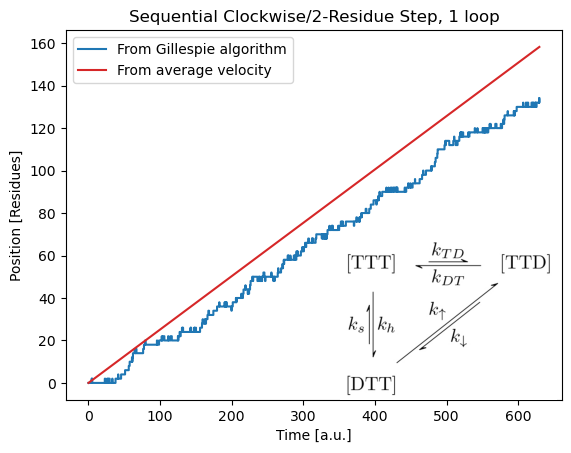

In [295]:
# If positive, potential increases when chaperone goes up, i.e. it favors going
# down.
potential_over_temperature = 0.1
SC_2R_1_loop = SC2R1Loop()
for _, _, attributes in SC_2R_1_loop.kinetic_scheme.edges(data=True):
    if 'position' in attributes and attributes['position'] > 0:
        old_rate_lambda = attributes['rate']
        attributes['rate'] = (
            lambda old_rate_lambda=old_rate_lambda: 
                old_rate_lambda() * np.exp(-potential_over_temperature))
    elif 'position' in attributes and attributes['position'] < 0:
        old_rate_lambda = attributes['rate']
        attributes['rate'] = (
            lambda old_rate_lambda=old_rate_lambda: 
                old_rate_lambda() * np.exp(potential_over_temperature))

SC_2R_1_loop_position = SC_2R_1_loop.gillespie(
    n_steps=1000, 
    n_simulations=1, 
    cumulative_sums={'position': 'displacement'})

ax = SC_2R_1_loop.plot_position_evolution(
    SC_2R_1_loop_position[['timestamp', 'position']],
    time_unit=r"a.u.", 
    position_unit="Residues", 
    kinetic_scheme_image_path="SC_2R_1_loop_kinetic_scheme.jpg",
    title="Sequential Clockwise/2-Residue Step, 1 loop"
)

## Defective protomer

## 